In [67]:
#packages
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

## Load Data

In [68]:
# load data set
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.tail()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## Exploratory Data Analysis

In [69]:
# check shape, nulls, dtypes
df.info()
df.nunique()

# unique ID check
df['customerID'].is_unique

# detect mis-typed numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

# preview problematic rows
df[df['TotalCharges'].isna()][['customerID','tenure','MonthlyCharges','TotalCharges']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,NaN
753,3115-CZMZD,0,20.25,NaN
936,5709-LVOEQ,0,80.85,NaN
1082,4367-NUYAO,0,25.75,NaN
1340,1371-DWPAZ,0,56.05,NaN
3331,7644-OMVMY,0,19.85,NaN
3826,3213-VVOLG,0,25.35,NaN
4380,2520-SGTTA,0,20.00,NaN
5218,2923-ARZLG,0,19.70,NaN
6670,4075-WKNIU,0,73.35,NaN


In [70]:
# missing values
df.isna().sum().sort_values(ascending = False)

TotalCharges        11
customerID           0
DeviceProtection     0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
OnlineBackup         0
gender               0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
SeniorCitizen        0
Churn                0
dtype: int64

In [71]:
# duplicates
df.duplicated('customerID').sum()


np.int64(0)

In [72]:
# outliers & range
df[['tenure','MonthlyCharges']].describe()


,tenure,MonthlyCharges
count,7043.000000,7043.000000
mean,32.371149,64.761692
std,24.559481,30.090047
min,0.000000,18.250000
25%,9.000000,35.500000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.750000


In [73]:
# target balance
df['Churn'].value_counts(normalize = True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [74]:
# dummify
obj_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

tri_like = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for c in tri_like:
    if c in df.columns:
        df[c] = df[c].replace({
            'No internet service': 'No service',
            'No phone service': 'No service'
        })

ignore = {'customerID', 'Churn'}
cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c not in ignore]

def is_yes_no_series(s):
    vals = set(s.dropna().unique())
    return vals.issubset({'Yes', 'No'}) and len(vals) > 0

bin_yesno = [c for c in cat_cols if is_yes_no_series(df[c])]
remaining = [c for c in cat_cols if c not in bin_yesno]
bin_other = [c for c in remaining if df[c].nunique(dropna = True) == 2]
multi = [c for c in remaining if df[c].nunique(dropna = True) >= 3]

for c in bin_yesno:
    df[c] = df[c].map({'Yes': 1, 'No': 0}).astype('int8')

for c in bin_other:
    d = pd.get_dummies(df[c], prefix = f'is_{c}', drop_first=True, dtype='int8')
    df[d.columns] = d
    df.drop(columns=[c], inplace = True)

if multi:
    d_multi = pd.get_dummies(df[multi],
                             prefix = [f'is_{c}' for c in multi],
                             columns = multi,
                             dtype='int8')
    df[d_multi.columns] = d_multi
    df.drop(columns = multi, inplace = True)



# target variable
df['ChurnFlag'] = df['Churn'].map({'Yes': 1, 'No': 0}).astype('int8')

df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,is_StreamingMovies_No service,is_StreamingMovies_Yes,is_Contract_Month-to-month,is_Contract_One year,is_Contract_Two year,is_PaymentMethod_Bank transfer (automatic),is_PaymentMethod_Credit card (automatic),is_PaymentMethod_Electronic check,is_PaymentMethod_Mailed check,ChurnFlag
0,7590-VHVEG,0,1,0,1,0,1,29.85,29.85,No,...,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,0,0,0,34,1,0,56.95,1889.50,No,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,0,0,0,2,1,1,53.85,108.15,Yes,...,0,0,1,0,0,0,0,0,1,1
3,7795-CFOCW,0,0,0,45,0,0,42.30,1840.75,No,...,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,0,0,0,2,1,1,70.70,151.65,Yes,...,0,0,1,0,0,0,0,1,0,1


In [75]:
# derived features
df['has_internet'] = (df.get('is_InternetService__No', pd.Series(0, index = df.index)) == 0).astype('int8')

tri_yes_cols = [c for c in df.columns if c.startswith('is_OnlineSecurity__Yes')
                or c.startswith('is_OnlineBackup__Yes')
                or c.startswith('is_DeviceProtection__Yes')
                or c.startswith('is_TechSupport__Yes')
                or c.startswith('is_StreamingTV__Yes')
                or c.startswith('is_StreamingMovies__Yes')
                or c.startswith('is_MultipleLines__Yes')]

phone_bit = ['PhoneService'] if 'PhoneService' in df.columns else []

df['service_count'] = df[phone_bit + tri_yes_cols].sum(axis = 1).astype('int16')

df['avg_charge_per_service'] = (df['MonthlyCharges'] / np.maximum(df['service_count'], 1)).astype(float)

if 'is_Contract__Month-to-month' in df.columns:
    df['is_month_to_month'] = df['is_Contract__Month-to-month'].astype('int8')
else:
    if 'Contract' in df.columns:
        df['is_month_to_month'] = (df['Contract'] == 'Month-to-month').astype('int8')
        
df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,is_Contract_One year,is_Contract_Two year,is_PaymentMethod_Bank transfer (automatic),is_PaymentMethod_Credit card (automatic),is_PaymentMethod_Electronic check,is_PaymentMethod_Mailed check,ChurnFlag,has_internet,service_count,avg_charge_per_service
0,7590-VHVEG,0,1,0,1,0,1,29.85,29.85,No,...,0,0,0,0,1,0,0,1,0,29.85
1,5575-GNVDE,0,0,0,34,1,0,56.95,1889.50,No,...,1,0,0,0,0,1,0,1,1,56.95
2,3668-QPYBK,0,0,0,2,1,1,53.85,108.15,Yes,...,0,0,0,0,0,1,1,1,1,53.85
3,7795-CFOCW,0,0,0,45,0,0,42.30,1840.75,No,...,1,0,1,0,0,0,0,1,0,42.30
4,9237-HQITU,0,0,0,2,1,1,70.70,151.65,Yes,...,0,0,0,0,1,0,1,1,1,70.70


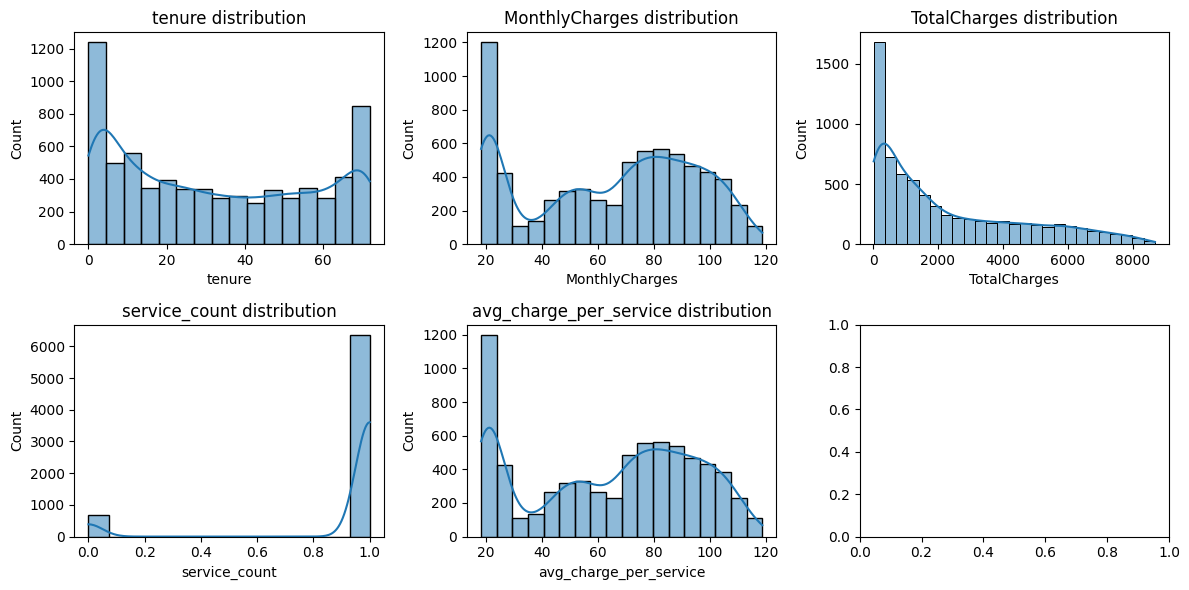

<Figure size 640x480 with 0 Axes>

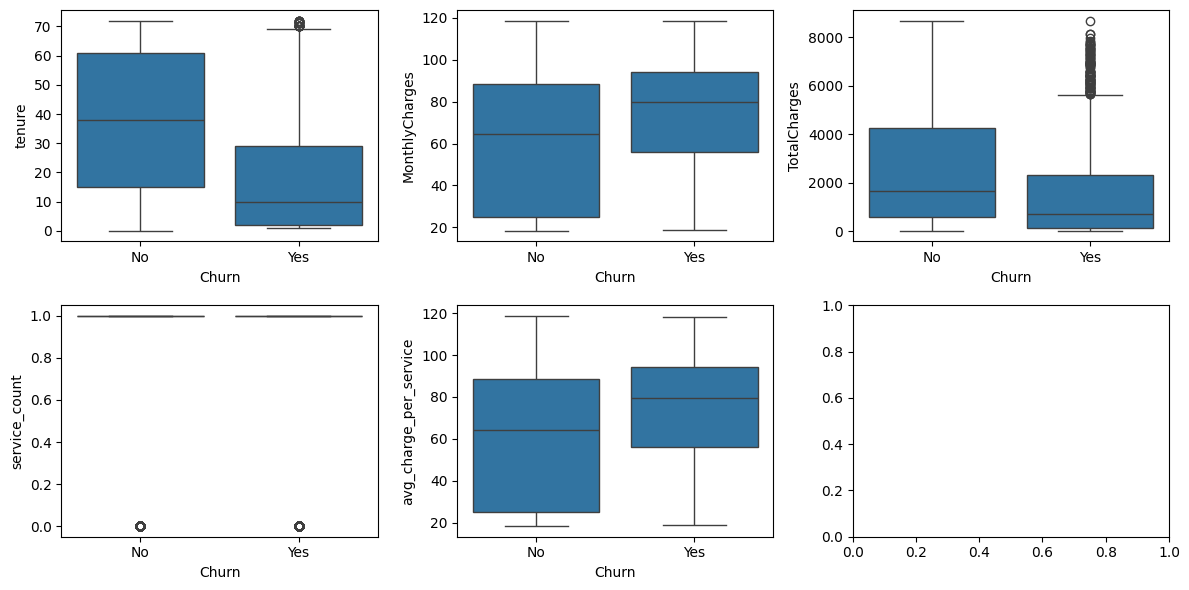

<Figure size 640x480 with 0 Axes>

In [ ]:
# distribution
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'service_count', 'avg_charge_per_service']

fig, axes = plt.subplots(2, 3, figsize = (12, 6))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(df[col], kde = True, ax=ax)
    ax.set_title(f'{col} distribution')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize = (12, 6))
sns.boxplot(x = 'Churn', y = 'tenure', data = df, ax = axes[0,0])
sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = df, ax = axes[0,1])
sns.boxplot(x = 'Churn', y = 'TotalCharges', data = df, ax = axes[0,2])
sns.boxplot(x = 'Churn', y = 'service_count', data = df, ax = axes[1,0])
sns.boxplot(x = 'Churn', y ='avg_charge_per_service', data = df, ax = axes[1,1])

plt.tight_layout()
plt.show()


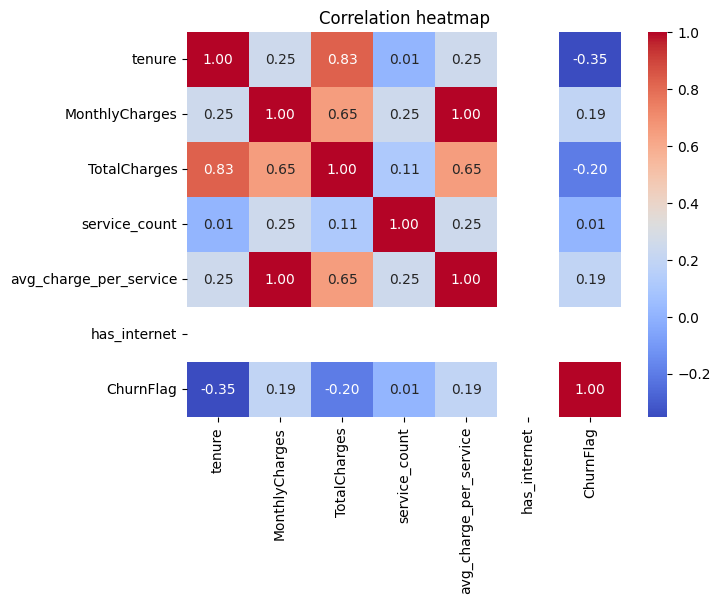

<Figure size 640x480 with 0 Axes>

In [ ]:
# correlation
corr_cols = ['tenure','MonthlyCharges','TotalCharges',
             'service_count','avg_charge_per_service',
             'has_internet','ChurnFlag']

plt.figure(figsize = (7,5))
sns.heatmap(df[corr_cols].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation heatmap')
plt.show()

## Model